# General data processing pipeline

## Image preprocessing   

In [2]:
subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
curSubject = subject_Names[0]
print(curSubject)

Audi


## Downsample the images

In [4]:
from PIL import Image
import os
import glob

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely

def downsample_image(image_path, max_pixels=16000000*0.9):
    """
    Downsamples an image to ensure it is lower than the specified number of pixels.
    
    :param image_path: Path to the image file
    :param max_pixels: Maximum number of pixels (default is 16 megapixels)
    """
    sliceName = os.path.basename(image_path)
    curDir = os.path.dirname(image_path)
    # parentDir = os.path.dirname(curDir)
    save_dir = os.path.join(curDir, "downsampled_CellPose/")
    os.makedirs(save_dir, exist_ok=True)
    
    # Change the file extension to .png, because DeepSlice loves that
    sliceName_png = os.path.splitext(sliceName)[0] + '.png'
    with Image.open(image_path) as img:
        width, height = img.size
        total_pixels = width * height
        
        if total_pixels > max_pixels:
            scale_factor = (max_pixels / total_pixels) ** 0.5
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)
            
            # img = img.resize((new_width, new_height), Image.ANTIALIAS)
            img = img.resize((new_width, new_height), Image.LANCZOS)
            img.save(os.path.join(save_dir, sliceName_png))
            print(f"Downsampled {image_path} to {new_width}x{new_height} pixels.")
        else:
            img.save(os.path.join(save_dir, sliceName_png))
            print(f"{image_path} is already below the maximum pixel limit.")

# # Directory containing the images
# image_dir_raw = "C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/"

# # Process all TIFF and PNG images in the directory
# for image_path in glob.glob(os.path.join(image_dir_raw, "*.tif")) + glob.glob(os.path.join(image_dir_raw, "*.png")):
#     downsample_image(image_path)

In [ ]:
# Downsample the images for all the subjects
for curSubject in subject_Names:
    image_dir_raw = f"C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/"
    for image_path in glob.glob(os.path.join(image_dir_raw, "*.tif")) + glob.glob(os.path.join(image_dir_raw, "*.png")):
        downsample_image(image_path)


NameError: name 'glob' is not defined

## Convert TIF to PNG

In [2]:
import os
import glob
from PIL import Image

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely
for curSubject in subject_Names:
    image_dir_raw = f"C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/"
    # Create a subfolder named "Raw_PNG" to save the converted PNG images
    image_save_dir = os.path.join(image_dir_raw, "Raw_PNG/")
    os.makedirs(image_save_dir, exist_ok=True)
    for image_path in glob.glob(os.path.join(image_dir_raw, "*.tif")):
        # Convert to PNG without downsampling
        sliceName = os.path.basename(image_path)
        save_dir = os.path.join(image_dir_raw, "Raw_PNG/")
        os.makedirs(save_dir, exist_ok=True)
        sliceName_png = os.path.splitext(sliceName)[0] + '.png'
        with Image.open(image_path) as img:
            img.save(os.path.join(save_dir, sliceName_png))
        print(f"Converted {image_path} to PNG at {os.path.join(save_dir, sliceName_png)}")   

Converted C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi\Audi_export_1.tif to PNG at C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG/Audi_export_1.png
Converted C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi\Audi_export_10.tif to PNG at C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG/Audi_export_10.png
Converted C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi\Audi_export_11.tif to PNG at C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG/Audi_export_11.png
Converted C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi\Audi_export_12.tif to PNG at C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG/Audi_export_12.png
Converted C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi\Audi_export_13.tif to PNG at C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG/Audi_export

## High pass filtering all the raw png images

In [30]:
import os
import glob
import numpy as np
from PIL import Image, ImageFilter
import cv2

def apply_highpass_filter(image_path, save_path, kernel_size=15, method='gaussian'):
    """
    Apply high-pass filter to remove background noise from large images
    
    Args:
        image_path: Path to input image
        save_path: Path to save filtered image
        kernel_size: Size of the kernel for filtering (larger = more background removal)
        method: 'gaussian' or 'unsharp' or 'kernel'
    """
    print(f"Loading image: {os.path.basename(image_path)}")
    
    # Load image
    img = Image.open(image_path)
    
    # Convert to numpy array for processing
    img_array = np.array(img)
    
    if method == 'gaussian':
        # Method 1: Gaussian-based high-pass filter
        # Create low-pass version by applying Gaussian blur
        if len(img_array.shape) == 3:  # Color image
            # Process each channel separately for better memory management
            result = np.zeros_like(img_array)
            for channel in range(img_array.shape[2]):
                channel_data = img_array[:, :, channel].astype(np.float32)
                # Apply Gaussian blur to get low-frequency components
                low_pass = cv2.GaussianBlur(channel_data, (kernel_size, kernel_size), 0)
                # Subtract low-pass from original to get high-pass
                high_pass = channel_data - low_pass
                # Add back some of the original to avoid too dark result
                result[:, :, channel] = np.clip(high_pass + 0, 0, 255).astype(np.uint8)
        else:  # Grayscale image
            img_float = img_array.astype(np.float32)
            low_pass = cv2.GaussianBlur(img_float, (kernel_size, kernel_size), 0)
            high_pass = img_float - low_pass
            result = np.clip(high_pass + 0, 0, 255).astype(np.uint8)
    
    elif method == 'unsharp':
        # Method 2: Unsharp masking (enhances edges)
        if len(img_array.shape) == 3:
            result = np.zeros_like(img_array)
            for channel in range(img_array.shape[2]):
                channel_data = img_array[:, :, channel].astype(np.float32)
                blurred = cv2.GaussianBlur(channel_data, (kernel_size, kernel_size), 0)
                # Unsharp mask: original + alpha * (original - blurred)
                alpha = 1.5  # Strength of the effect
                unsharp = channel_data + alpha * (channel_data - blurred)
                result[:, :, channel] = np.clip(unsharp, 0, 255).astype(np.uint8)
        else:
            img_float = img_array.astype(np.float32)
            blurred = cv2.GaussianBlur(img_float, (kernel_size, kernel_size), 0)
            alpha = 1.5
            unsharp = img_float + alpha * (img_float - blurred)
            result = np.clip(unsharp, 0, 255).astype(np.uint8)
    
    elif method == 'kernel':
        # Method 3: Direct kernel-based high-pass filter
        # High-pass kernel
        kernel = np.array([[-1, -1, -1],
                          [-1,  9, -1],
                          [-1, -1, -1]])
        
        if len(img_array.shape) == 3:
            result = np.zeros_like(img_array)
            for channel in range(img_array.shape[2]):
                filtered = cv2.filter2D(img_array[:, :, channel], -1, kernel)
                result[:, :, channel] = np.clip(filtered + 100, 0, 255).astype(np.uint8)
        else:
            filtered = cv2.filter2D(img_array, -1, kernel)
            result = np.clip(filtered + 100, 0, 255).astype(np.uint8)
    
    # Convert back to PIL Image and save
    result_img = Image.fromarray(result)
    result_img.save(save_path, optimize=True, quality=95)
    print(f"Saved filtered image to: {save_path}")

# Main processing code
subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
curSubject = subject_Names[0]
print(f"Processing subject: {curSubject}")

# Increase PIL's image size limit for large images
Image.MAX_IMAGE_PIXELS = 400000000  # 400 megapixels

# # Set up directories
# raw_png_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/"
# save_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/HighPass/"
# os.makedirs(save_dir, exist_ok=True)

# # Process all PNG files
# for image_path in glob.glob(os.path.join(raw_png_dir, "*.png")):
#     slice_name = os.path.basename(image_path)
#     save_path = os.path.join(save_dir, slice_name)
    
#     print(f"Processing {slice_name}")
    
#     try:
#         # Apply high-pass filter
#         # You can adjust kernel_size (larger = more background removal)
#         # and method ('gaussian', 'unsharp', or 'kernel')
#         apply_highpass_filter(image_path, save_path, kernel_size=501, method='gaussian')
        
#         print(f"Successfully processed {slice_name}")
        
#     except Exception as e:
#         print(f"Error processing {slice_name}: {str(e)}")
#         continue



# Optional: Process all subjects
for subject in subject_Names:
    print(f"\nProcessing subject: {subject}")
    curSubject = subject
    raw_png_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/"
    save_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/HighPass/"
    os.makedirs(save_dir, exist_ok=True)
    
    for image_path in glob.glob(os.path.join(raw_png_dir, "*.png")):
        slice_name = os.path.basename(image_path)
        save_path = os.path.join(save_dir, slice_name)
        
        try:
            apply_highpass_filter(image_path, save_path, kernel_size=501, method='gaussian')
        except Exception as e:
            print(f"Error processing {slice_name}: {str(e)}")
            continue

print("High-pass filtering complete!")

Processing subject: Audi

Processing subject: Audi
Loading image: Audi_export_1.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_1.png
Loading image: Audi_export_10.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_10.png
Loading image: Audi_export_11.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_11.png
Loading image: Audi_export_12.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_12.png
Loading image: Audi_export_13.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_13.png
Loading image: Audi_export_14.png
Saved filtered image to: C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_14.png
Loading image: 

KeyboardInterrupt: 

In [1]:
import torch

print("=== PyTorch Installation Test ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    try:
        print(f"CUDA version: {torch.version.cuda}")
        print(f"GPU count: {torch.cuda.device_count()}")
        print(f"GPU name: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        
        # Test actual GPU computation
        x = torch.randn(100, 100).cuda()
        y = x.sum()
        print("✓ GPU computation successful!")
        
    except Exception as e:
        print(f"❌ GPU test failed: {e}")
else:
    print("❌ CUDA not available")

=== PyTorch Installation Test ===
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU
GPU memory: 8.6 GB
✓ GPU computation successful!


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import math
import gc

def create_gaussian_kernel(kernel_size, sigma=None):
    """Create a 2D Gaussian kernel for convolution"""
    if sigma is None:
        sigma = kernel_size / 6.0
    
    # Create coordinate grids
    coords = torch.arange(kernel_size, dtype=torch.float32)
    coords -= kernel_size // 2
    
    # Create 2D Gaussian
    g = torch.exp(-(coords**2) / (2 * sigma**2))
    g2d = g[:, None] * g[None, :]
    g2d = g2d / g2d.sum()
    
    return g2d.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, kernel_size, kernel_size)

def apply_highpass_filter_gpu(image_path, save_path, kernel_size=501, chunk_size=4096):
    """
    GPU-accelerated high-pass filter with memory management for large images
    
    Args:
        image_path: Path to input image
        save_path: Path to save filtered image
        kernel_size: Size of Gaussian kernel (should be odd)
        chunk_size: Process image in chunks to manage GPU memory
    """
    print(f"Loading large image: {os.path.basename(image_path)}")
    
    # Check GPU availability
    if torch.cuda.is_available():
        try:
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        except Exception as e:
            print(f"GPU available but corrupted PyTorch installation: {e}")
            print("Falling back to CPU processing...")
            device = torch.device('cpu')
    else:
        print("CUDA not available, using CPU")
        device = torch.device('cpu')
    
    # Load image
    img = Image.open(image_path)
    print(f"Image size: {img.size}, Mode: {img.mode}")
    
    # Convert to numpy array
    img_array = np.array(img)
    original_dtype = img_array.dtype
    height, width = img_array.shape[:2]
    
    print(f"Image shape: {img_array.shape}")
    print(f"Estimated GPU memory needed: {img_array.nbytes * 3 / 1e9:.1f} GB")
    
    # Determine if we need to process in chunks
    estimated_memory_gb = img_array.nbytes * 3 / 1e9  # Original + blurred + result
    available_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9 * 0.8  # Use 80% of VRAM
    
    if estimated_memory_gb > available_memory_gb:
        print(f"Image too large for GPU memory. Processing in chunks of {chunk_size}x{chunk_size}")
        result = process_in_chunks_gpu(img_array, kernel_size, chunk_size, device)
    else:
        print("Processing entire image on GPU")
        result = process_full_image_gpu(img_array, kernel_size, device)
    
    # Save result
    result_img = Image.fromarray(result.astype(original_dtype))
    result_img.save(save_path, optimize=True, quality=95)
    print(f"Saved filtered image to: {save_path}")
    
    # Clean up GPU memory
    torch.cuda.empty_cache()

def process_full_image_gpu(img_array, kernel_size, device):
    """Process entire image on GPU (for smaller images)"""
    
    # Convert to tensor and move to GPU
    if len(img_array.shape) == 3:  # Color image
        # Convert to float32 and normalize to [0, 1]
        img_tensor = torch.from_numpy(img_array).float().to(device) / 255.0
        # Reshape to (batch, channels, height, width)
        img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
        num_channels = img_array.shape[2]
    else:  # Grayscale
        img_tensor = torch.from_numpy(img_array).float().to(device) / 255.0
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
        num_channels = 1
    
    # Create Gaussian kernel
    kernel = create_gaussian_kernel(kernel_size).to(device)
    
    # Apply Gaussian blur to each channel
    with torch.no_grad():
        if num_channels > 1:
            # Process each channel separately to save memory
            blurred_channels = []
            for c in range(num_channels):
                channel = img_tensor[:, c:c+1, :, :]
                blurred_channel = F.conv2d(channel, kernel, padding='same')
                blurred_channels.append(blurred_channel)
            blurred_tensor = torch.cat(blurred_channels, dim=1)
        else:
            blurred_tensor = F.conv2d(img_tensor, kernel, padding='same')
        
        # High-pass filter: original - blurred
        high_pass_tensor = img_tensor - blurred_tensor
        
        # Convert back to numpy
        if num_channels > 1:
            result = high_pass_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        else:
            result = high_pass_tensor.squeeze().cpu().numpy()
    
    # Convert back to original range [0, 255] and clip negative values
    result = np.clip(result * 255.0, 0, 255)  # Clip to [0, 255], negatives become 0 (black)
    
    return result

def process_in_chunks_gpu(img_array, kernel_size, chunk_size, device):
    """Process image in overlapping chunks to manage GPU memory"""
    
    height, width = img_array.shape[:2]
    is_color = len(img_array.shape) == 3
    
    # Calculate overlap needed for proper filtering
    overlap = kernel_size // 2
    
    # Initialize result array
    result = np.zeros_like(img_array, dtype=np.float32)
    
    # Create Gaussian kernel
    kernel = create_gaussian_kernel(kernel_size).to(device)
    
    # Process chunks with overlap
    for y in range(0, height, chunk_size - overlap):
        for x in range(0, width, chunk_size - overlap):
            print(f"Processing chunk at ({y}, {x})")
            
            # Define chunk boundaries with overlap
            y_start = max(0, y)
            y_end = min(height, y + chunk_size)
            x_start = max(0, x)
            x_end = min(width, x + chunk_size)
            
            # Extract chunk
            if is_color:
                chunk = img_array[y_start:y_end, x_start:x_end, :]
            else:
                chunk = img_array[y_start:y_end, x_start:x_end]
            
            # Process chunk on GPU
            processed_chunk = process_full_image_gpu(chunk, kernel_size, device)
            
            # Calculate where to place the result (avoiding overlap regions)
            result_y_start = y_start if y == 0 else y_start + overlap//2
            result_y_end = y_end if y_end == height else y_end - overlap//2
            result_x_start = x_start if x == 0 else x_start + overlap//2
            result_x_end = x_end if x_end == width else x_end - overlap//2
            
            # Map back to chunk coordinates
            chunk_y_start = result_y_start - y_start
            chunk_y_end = chunk_y_start + (result_y_end - result_y_start)
            chunk_x_start = result_x_start - x_start
            chunk_x_end = chunk_x_start + (result_x_end - result_x_start)
            
            # Place processed chunk in result
            if is_color:
                result[result_y_start:result_y_end, result_x_start:result_x_end, :] = \
                    processed_chunk[chunk_y_start:chunk_y_end, chunk_x_start:chunk_x_end, :]
            else:
                result[result_y_start:result_y_end, result_x_start:result_x_end] = \
                    processed_chunk[chunk_y_start:chunk_y_end, chunk_x_start:chunk_x_end]
            
            # Clear GPU memory
            torch.cuda.empty_cache()
    
    return result

# Main processing code with GPU acceleration
def main():
    subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
    
    # Increase PIL's image size limit for large images
    Image.MAX_IMAGE_PIXELS = 400000000  # 400 megapixels
    
    # Process all subjects
    for subject in subject_Names[-3:]:  # Process last 3 subjects
        print(f"\n{'='*50}")
        print(f"Processing subject: {subject}")
        print(f"{'='*50}")
        
        raw_png_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{subject}/Raw_PNG/"
        save_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{subject}/HighPass_GPU/"
        os.makedirs(save_dir, exist_ok=True)
        
        # Get all image files (PNG and TIFF)
        image_patterns = [
            os.path.join(raw_png_dir, "*.png"),
            os.path.join(raw_png_dir, "*.tif"),
            os.path.join(raw_png_dir, "*.tiff")
        ]
        
        image_files = []
        for pattern in image_patterns:
            image_files.extend(glob.glob(pattern))
        
        print(f"Found {len(image_files)} images to process")
        
        for i, image_path in enumerate(image_files):
            slice_name = os.path.basename(image_path)
            name_without_ext = os.path.splitext(slice_name)[0]
            save_path = os.path.join(save_dir, f"{name_without_ext}_highpass.png")
            
            print(f"\n[{i+1}/{len(image_files)}] Processing {slice_name}")
            
            try:
                # GPU-accelerated high-pass filter
                apply_highpass_filter_gpu(
                    image_path, 
                    save_path, 
                    kernel_size=501,  # Large kernel for background removal
                    chunk_size=4096   # Adjust based on your GPU memory
                )
                
                print(f"✓ Successfully processed {slice_name}")
                
            except Exception as e:
                print(f"✗ Error processing {slice_name}: {str(e)}")
                # Clean up GPU memory even on error
                torch.cuda.empty_cache()
                continue
    
    print("\n" + "="*50)
    print("GPU High-pass filtering complete!")
    print("="*50)

if __name__ == "__main__":
    main()


Processing subject: Liam
Found 12 images to process

[1/12] Processing liam slide 1-Stitching-07_c2.png
Loading large image: liam slide 1-Stitching-07_c2.png
Using GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU Memory: 8.6 GB
Image size: (14816, 10188), Mode: RGB
Image shape: (10188, 14816, 3)
Estimated GPU memory needed: 1.4 GB
Processing entire image on GPU


In [ ]:
import os
import glob
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import math
import gc

def create_gaussian_kernel_1d(kernel_size, sigma=None):
    """Create a 1D Gaussian kernel for separable convolution (much faster)"""
    if sigma is None:
        sigma = kernel_size / 6.0
    
    coords = torch.arange(kernel_size, dtype=torch.float32)
    coords -= kernel_size // 2
    
    g = torch.exp(-(coords**2) / (2 * sigma**2))
    g = g / g.sum()
    
    return g.unsqueeze(0).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 1, kernel_size)

def apply_highpass_filter_gpu(image_path, save_path, kernel_size=501, chunk_size=4096):
    """
    GPU-accelerated high-pass filter with memory management for large images
    
    Args:
        image_path: Path to input image
        save_path: Path to save filtered image
        kernel_size: Size of Gaussian kernel (should be odd)
        chunk_size: Process image in chunks to manage GPU memory
    """
    print(f"Loading large image: {os.path.basename(image_path)}")
    
    # Check GPU availability
    if torch.cuda.is_available():
        try:
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        except Exception as e:
            print(f"GPU available but corrupted PyTorch installation: {e}")
            print("Falling back to CPU processing...")
            device = torch.device('cpu')
    else:
        print("CUDA not available, using CPU")
        device = torch.device('cpu')
    
    # Load image
    img = Image.open(image_path)
    print(f"Image size: {img.size}, Mode: {img.mode}")
    
    # Convert to numpy array
    img_array = np.array(img)
    original_dtype = img_array.dtype
    height, width = img_array.shape[:2]
    
    print(f"Image shape: {img_array.shape}")
    print(f"Estimated GPU memory needed: {img_array.nbytes * 3 / 1e9:.1f} GB")
    
    # Determine if we need to process in chunks
    estimated_memory_gb = img_array.nbytes * 3 / 1e9  # Original + blurred + result
    available_memory_gb = 6.0  # Conservative estimate for 8GB laptop GPU
    
    if estimated_memory_gb > available_memory_gb:
        print(f"Image too large for GPU memory. Processing in chunks of {chunk_size}x{chunk_size}")
        result = process_in_chunks_gpu(img_array, kernel_size, chunk_size, device)
    else:
        print("Processing entire image on GPU")
        result = process_full_image_gpu(img_array, kernel_size, device)
    
    # Save result
    result_img = Image.fromarray(result.astype(original_dtype))
    result_img.save(save_path, optimize=True, quality=95)
    print(f"Saved filtered image to: {save_path}")
    
    # Clean up GPU memory
    torch.cuda.empty_cache()

def process_full_image_gpu(img_array, kernel_size, device):
    """Process entire image on GPU (for smaller images)"""
    
    # Convert to tensor and move to GPU
    if len(img_array.shape) == 3:  # Color image
        # Convert to float32 and normalize to [0, 1]
        img_tensor = torch.from_numpy(img_array).float().to(device) / 255.0
        # Reshape to (batch, channels, height, width)
        img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
        num_channels = img_array.shape[2]
    else:  # Grayscale
        img_tensor = torch.from_numpy(img_array).float().to(device) / 255.0
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)
        num_channels = 1
    
    # Create 1D Gaussian kernel for separable convolution
    kernel_1d = create_gaussian_kernel_1d(kernel_size).to(device)
    kernel_h = kernel_1d  # Horizontal kernel
    kernel_v = kernel_1d.transpose(-1, -2)  # Vertical kernel (transpose last 2 dims)
    
    # Apply separable Gaussian blur (much faster than 2D convolution)
    with torch.no_grad():
        if num_channels > 1:
            # Process each channel separately to save memory
            blurred_channels = []
            for c in range(num_channels):
                channel = img_tensor[:, c:c+1, :, :]
                # Apply horizontal blur first
                blurred_h = F.conv2d(channel, kernel_h, padding='same')
                # Then vertical blur
                blurred_channel = F.conv2d(blurred_h, kernel_v, padding='same')
                blurred_channels.append(blurred_channel)
            blurred_tensor = torch.cat(blurred_channels, dim=1)
        else:
            # Apply horizontal then vertical blur
            blurred_h = F.conv2d(img_tensor, kernel_h, padding='same')
            blurred_tensor = F.conv2d(blurred_h, kernel_v, padding='same')
        
        # High-pass filter: original - blurred
        high_pass_tensor = img_tensor - blurred_tensor
        
        # Convert back to numpy
        if num_channels > 1:
            result = high_pass_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        else:
            result = high_pass_tensor.squeeze().cpu().numpy()
    
    # Convert back to original range [0, 255] and clip negative values
    result = np.clip(result * 255.0, 0, 255)  # Clip to [0, 255], negatives become 0 (black)
    
    return result

def process_in_chunks_gpu(img_array, kernel_size, chunk_size, device):
    """Process image in overlapping chunks to manage GPU memory"""
    
    height, width = img_array.shape[:2]
    is_color = len(img_array.shape) == 3
    
    # Calculate overlap needed for proper filtering
    overlap = kernel_size // 2
    
    # Initialize result array
    result = np.zeros_like(img_array, dtype=np.float32)
    
    # Create Gaussian kernel
    kernel = create_gaussian_kernel(kernel_size).to(device)
    
    # Process chunks with overlap
    for y in range(0, height, chunk_size - overlap):
        for x in range(0, width, chunk_size - overlap):
            print(f"Processing chunk at ({y}, {x})")
            
            # Define chunk boundaries with overlap
            y_start = max(0, y)
            y_end = min(height, y + chunk_size)
            x_start = max(0, x)
            x_end = min(width, x + chunk_size)
            
            # Extract chunk
            if is_color:
                chunk = img_array[y_start:y_end, x_start:x_end, :]
            else:
                chunk = img_array[y_start:y_end, x_start:x_end]
            
            # Process chunk on GPU
            processed_chunk = process_full_image_gpu(chunk, kernel_size, device)
            
            # Calculate where to place the result (avoiding overlap regions)
            result_y_start = y_start if y == 0 else y_start + overlap//2
            result_y_end = y_end if y_end == height else y_end - overlap//2
            result_x_start = x_start if x == 0 else x_start + overlap//2
            result_x_end = x_end if x_end == width else x_end - overlap//2
            
            # Map back to chunk coordinates
            chunk_y_start = result_y_start - y_start
            chunk_y_end = chunk_y_start + (result_y_end - result_y_start)
            chunk_x_start = result_x_start - x_start
            chunk_x_end = chunk_x_start + (result_x_end - result_x_start)
            
            # Place processed chunk in result
            if is_color:
                result[result_y_start:result_y_end, result_x_start:result_x_end, :] = \
                    processed_chunk[chunk_y_start:chunk_y_end, chunk_x_start:chunk_x_end, :]
            else:
                result[result_y_start:result_y_end, result_x_start:result_x_end] = \
                    processed_chunk[chunk_y_start:chunk_y_end, chunk_x_start:chunk_x_end]
            
            # Clear GPU memory
            torch.cuda.empty_cache()
    
    return result

# Main processing code with GPU acceleration
def main():
    subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
    
    # Increase PIL's image size limit for large images
    Image.MAX_IMAGE_PIXELS = 400000000  # 400 megapixels
    
    # Process all subjects
    for subject in subject_Names:
        print(f"\n{'='*50}")
        print(f"Processing subject: {subject}")
        print(f"{'='*50}")
        
        raw_png_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{subject}/Raw_PNG/"
        save_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{subject}/HighPass_GPU/"
        os.makedirs(save_dir, exist_ok=True)
        
        # Get all image files (PNG and TIFF)
        image_patterns = [
            os.path.join(raw_png_dir, "*.png"),
            os.path.join(raw_png_dir, "*.tif"),
            os.path.join(raw_png_dir, "*.tiff")
        ]
        
        image_files = []
        for pattern in image_patterns:
            image_files.extend(glob.glob(pattern))
        
        print(f"Found {len(image_files)} images to process")
        
        for i, image_path in enumerate(image_files):
            slice_name = os.path.basename(image_path)
            name_without_ext = os.path.splitext(slice_name)[0]
            save_path = os.path.join(save_dir, f"{name_without_ext}_highpass.png")
            
            print(f"\n[{i+1}/{len(image_files)}] Processing {slice_name}")
            
            try:
                # GPU-accelerated high-pass filter
                apply_highpass_filter_gpu(
                    image_path, 
                    save_path, 
                    kernel_size=501,  # Large kernel for background removal
                    chunk_size=4096   # Adjust based on your GPU memory
                )
                
                print(f"✓ Successfully processed {slice_name}")
                
            except Exception as e:
                print(f"✗ Error processing {slice_name}: {str(e)}")
                # Clean up GPU memory even on error
                torch.cuda.empty_cache()
                continue
    
    print("\n" + "="*50)
    print("GPU High-pass filtering complete!")
    print("="*50)

if __name__ == "__main__":
    main()

Hello, world!


device(type='cuda')

In [7]:
import os
import glob
from PIL import Image

# High pass filter to remove background noise
subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
curSubject = subject_Names[0]
print(curSubject)
Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely
raw_png_dir = f"C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/"
save_dir = f"C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/HighPass/"
os.makedirs(save_dir, exist_ok=True)
for image_path in glob.glob(os.path.join(raw_png_dir, "*.png")):
    sliceName = os.path.basename(image_path)
    print(f"Processing {sliceName}")
    # High pass filter
    high_pass_filter(raw_png_dir, save_dir, kernel_size = 51)
    print(f"Applied high-pass filter to {image_path} and saved to {os.path.join(save_dir, sliceName_png)}")

Audi
Processing Audi_export_1.png
Applied high-pass filter to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG\Audi_export_1.png and saved to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_1.png
Applied high-pass filter to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG\Audi_export_10.png and saved to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_10.png
Applied high-pass filter to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/Raw_PNG\Audi_export_11.png and saved to C:Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/Audi/HighPass/Audi_export_11.png


KeyboardInterrupt: 

## Resgister the slices to atlas using DeepSlice

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
# pip install DeepSlice

from DeepSlice import DSModel
species = 'rat' #available species are 'mouse' and 'rat'

Model = DSModel(species)

In [ ]:
folderpath = image_dir_clean

In [ ]:
Model.predict(folderpath, ensemble=True, section_numbers=False) 

Found 18 validated image filenames.
18/18 [==============================] - 5s 283ms/step


In [ ]:
Model.propagate_angles()  

DV angle: 0.7777109976943023
ML angle: 1.694943489693149
DV angle: 0.7778468377130393
ML angle: 1.6949437436070511


In [ ]:
Model.predictions

,Filenames,ox,oy,oz,ux,uy,uz,vx,vy,vz,width,height
0,toyota_slide2_04_stitched.png,461.959704,490.276009,439.110005,-419.179312,-12.717386,23.087787,-13.593273,3.358491,-276.996275,4815,2990
1,toyota_slide2_02_stitched.png,472.654811,492.109673,435.970061,-430.734503,-13.276782,39.105269,-28.136818,3.238996,-299.892816,4711,3056
2,Experiment-7982-Shading Correction-32.png,461.227257,502.895189,438.553191,-438.538440,-13.278628,22.232359,-14.001835,3.547182,-291.784782,4730,3044
3,TOyota_02_c2.png,486.005517,513.313907,431.201961,-471.197870,-14.105521,11.955215,-7.996285,3.823610,-299.056091,4761,3023
4,Experiment-7985-Shading Correction-38.png,455.527791,535.308592,447.586019,-419.075952,-12.438280,2.755496,-2.499054,4.049026,-303.677375,4560,3157
5,TOyota_01_lzw_c2.png,475.006163,530.193786,448.222580,-447.204042,-13.246903,1.008822,-1.090946,4.305905,-319.529101,4561,3157
6,toyota_slide2_01_stitched.png,462.639292,531.234751,450.827703,-432.658236,-12.843464,2.996472,-2.999424,4.207142,-316.414353,4626,3112
7,toyota_slide3_04_stitched.png,461.019937,550.222444,441.632936,-426.308367,-12.779225,12.104618,-9.768999,3.913449,-309.536556,4500,3199
8,toyota_slide2_03_stitched.png,461.600938,542.109204,449.423239,-426.673648,-12.638114,0.914947,-1.758478,4.204901,-313.544601,4501,3199
9,Experiment-7984-Shading Correction-36.png,456.129918,554.067757,427.037922,-401.997818,-12.191372,21.791709,-15.454303,3.628581,-300.945983,4544,3168


In [ ]:
Model.save_predictions(folderpath + 'MyResults')      

18
saving to /mnt/c/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/clean/MyResults.json


Before the next step, always make sure the registration is correct on software like QuickNII

## Check the name of regions

## Mask out ROI with the transformed atlas slices

In [1]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4_asymmetric.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_FA_color_v1.01.nii"
# atlas_path = "/home/jifenge/Jasanoff_Lab/Rat_atlas/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_T2star_v1.01.nii"
atlas_data = nib.load(atlas_path).get_fdata()
print(atlas_data.shape)

(512, 1024, 512)


In [5]:
def parse_label_file(label_path):
    regions = []
    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
                
            parts = line.split()
            if len(parts) >= 7:  # ID R G B A Visibility Name
                try:
                    region_id = int(parts[0])
                    r, g, b = int(parts[1]), int(parts[2]), int(parts[3])
                    alpha = int(parts[4])
                    visibility = int(parts[5])
                    name = ' '.join(parts[7:])
                    
                    regions.append({
                        'id': region_id,
                        'name': name,
                        'color': (r, g, b),
                        'alpha': alpha,
                        'visible': visibility == 1
                    })
                except ValueError:
                    continue
                    
    return regions

# Usage
atlasLabel_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4.label"
regions = parse_label_file(atlasLabel_path)
print(f"Loaded {len(regions)} regions")

# Print first few regions
for region in regions[10:13]:
    print(f"ID: {region['id']}, Name: {region['name']}, Color: RGB{region['color']}")

# Function to lookup a region by ID
def region_index(region_info, regions):
    if isinstance(region_info, int):
        # If it's an integer, search by ID
        region_array = []
        for region in regions:
            if region['id'] == region_id:
                region_array.append(region)
                    
        return region_array
    elif isinstance(region_info, list):
        # If it's a list, search by each ID
        region_array = []
        for region_id in region_info:
            for region in regions:
                if region['id'] == region_id:
                    region_array.append(region)
        return region_array
    
    elif isinstance(region_info, np.ndarray):
        # If it's a numpy array, convert to a list of integers
        region_info = region_info.tolist()
        # Find the first match in the regions list
        region_array = []
        for region_id in region_info:
            for region in regions:
                if region['id'] == region_id:
                    region_array.append(region)
                    
        return region_array
    elif isinstance(region_info, str):
        # If it's a string, search by name
        region_array = []
        for region in regions:
            if region_info in region['name']:
                region_array.append(region)
        # If no match found, return None
        return region_array
    else:
        return None


import numpy as np

ROI_index = np.array([422])
ROI_name = region_index([422], regions)
print(ROI_name)

Loaded 223 regions
ID: 34, Name: "medial lemniscus, unspecified", Color: RGB(212, 255, 0)
ID: 35, Name: "facial nerve, unspecified", Color: RGB(255, 25, 240)
ID: 36, Name: "anterior commissure, anterior limb", Color: RGB(124, 252, 0)
[{'id': 422, 'name': '"Secondary somatosensory area"', 'color': (200, 100, 250), 'alpha': 1, 'visible': True}]


In [21]:
isinstance([422], int)

False

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def extract_section(atlas_data, origin, u_vector, v_vector, output_size=None):
    """
    Extract a 2D section from a 3D atlas using nearest neighbor sampling.
    
    Parameters:
    -----------
    atlas_data : numpy.ndarray
        3D atlas volume (can be a regular array or memory-mapped array)
    origin : numpy.ndarray or list
        Origin vector (O) - coordinates of the top-left corner of the section
    u_vector : numpy.ndarray or list
        U vector - vector from origin to top-right corner
    v_vector : numpy.ndarray or list
        V vector - vector from origin to bottom-left corner
    output_size : tuple or None
        Target size of the output section (width, height)
        If None, dimensions will be calculated from vector magnitudes
    
    Returns:
    --------
    section_image : numpy.ndarray
        2D image representing the extracted section
    """
    # Convert inputs to numpy arrays if they aren't already
    origin = np.array(origin)
    u_vector = np.array(u_vector)
    v_vector = np.array(v_vector)
    
    # If output_size not provided, use the magnitudes of the vectors
    if output_size is None:
        u_length = np.linalg.norm(u_vector)
        v_length = np.linalg.norm(v_vector)
        
        width = int(u_length)
        height = int(v_length)
        output_size = (width, height)
        # # Keep the aspect ratio, but limit maximum size to 1024 pixels
        # max_dim = 1024
        # scale = min(max_dim / u_length, max_dim / v_length)
        # width = max(int(u_length * scale), 1)
        # height = max(int(v_length * scale), 1)
        # output_size = (width, height)
    
    width, height = output_size
    
    # Create output image array
    section_image = np.zeros((height, width), dtype=atlas_data.dtype)
    
    # For each pixel in the output image, find the nearest voxel in the atlas
    for y in range(height):
        for x in range(width):
            # Calculate normalized coordinates within the section
            x_norm = x / (width - 1) if width > 1 else 0.5
            y_norm = y / (height - 1) if height > 1 else 0.5
            
            # Calculate the corresponding 3D position in atlas space
            # This is a weighted sum of the three vectors
            pos = origin + x_norm * u_vector + y_norm * v_vector
            
            # Round to nearest voxel coordinates (nearest neighbor sampling)
            x_atlas = int(round(pos[0]))
            y_atlas = int(round(pos[1]))
            z_atlas = int(round(pos[2]))
            
            # Ensure coordinates are within atlas bounds
            x_atlas = max(0, min(x_atlas, atlas_data.shape[0] - 1))
            y_atlas = max(0, min(y_atlas, atlas_data.shape[1] - 1))
            z_atlas = max(0, min(z_atlas, atlas_data.shape[2] - 1))
            
            # Sample the atlas at the nearest voxel
            section_image[y, x] = atlas_data[x_atlas, y_atlas, z_atlas]
    
    return section_image


import numpy as np
from skimage import transform

def upsample_and_pad_atlas_slice(atlas_slice, target_dims):
    """
    Upsample the atlas slice to match the target dimensions and apply symmetric zero-padding.
    
    Parameters:
    -----------
    atlas_slice : numpy.ndarray
        2D atlas slice array
    target_dims : tuple
        Target dimensions (height, width)
    
    Returns:
    --------
    padded_data : numpy.ndarray
        Upsampled and zero-padded atlas slice
    """
    # Calculate the scaling factor
    scale = min(target_dims[0] / atlas_slice.shape[0], target_dims[1] / atlas_slice.shape[1])
    
    # Upsample the atlas slice
    upsampled_data = transform.rescale(atlas_slice, scale, order=0, anti_aliasing=False, preserve_range=True)
    
    # Calculate the padding needed to match the target dimensions
    pad_height = target_dims[0] - upsampled_data.shape[0]
    pad_width = target_dims[1] - upsampled_data.shape[1]
    
    # Calculate symmetric padding
    pad_height_before = pad_height // 2
    pad_height_after = pad_height - pad_height_before
    pad_width_before = pad_width // 2
    pad_width_after = pad_width - pad_width_before
    
    # Apply symmetric zero-padding
    padded_data = np.pad(upsampled_data, 
                         ((pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), 
                         mode='constant', 
                         constant_values=0)
    
    return padded_data

### Menaully combine ROIs and define new indices

In [5]:
import numpy as np

Sen_L = np.array([227, 266, 294])
Sen_R = Sen_L+520
Mo_L = np.array([231,293,221])
Mo_R = Mo_L +520
# A_L = np.array([213,214,215,])
# A_R = A_L + 520
# MD_L = np.array([232,233,240])
# MD_R = MD_L + 520
# LP_L = np.array([283,285,286])
# LP_R = LP_L + 520
# LD_L = np.array([228,229])
# LD_R = LD_L + 520
# Int_L = np.array([246,247,248]) #267
# Int_R = Int_L + 520
# # ZI_L = np.array([164,200,204,235,238,272,280,281,284,287]) #164,200,204,235,238,272,280,281,284,287   
ZI_L = np.array([164,200,204,235,238,257,284,287])
ZI_R = ZI_L + 520
SC_L = np.array([50,55])
SC_R = SC_L + 520


AS_L = np.array([208,213,214,215,216,254,255,257,232,233,240,267,246,247,248])  # association
AS_R = AS_L + 520
Po_L = np.array([228,229,283,285,286,230])  #Po + LDLP
Po_R = Po_L + 520
PRT_L = np.array([94])
PRT_R = PRT_L + 520
#

In [6]:
ROI_index = np.array([407])
ROI_name = region_index(ROI_index, regions)
for roi in ROI_name:
    print(f"ID: {roi['id']}, Name: {roi['name']}")

ID: 407, Name: "Frontal association area 3"


In [7]:
ROI_list = [Sen_L,Sen_R,Mo_L,Mo_R,
            ZI_L,ZI_R,SC_L,SC_R, 
            AS_L,AS_R, Po_L,Po_R,
            PRT_L,PRT_R,]
ROI_num = [505,1025,506,1026,
           507,1027,508,1028,
           509,1029,510,1030,
           511,1031,]

In [8]:
ROI_num[12:]

[511, 1031]

In [14]:
# Create a dictionary of cerebral blood flow (CBF) values for each ROI
cbf_values = {
    # Manually defined regions
    505: 0.85,  # Sen_L
    1025: 0.85, # Sen_R
    506: 0.85,  # Mo_L
    1026: 0.85, # Mo_R
    507: 0.76,  # ZI_L
    1027: 0.76, # ZI_R
    508: 0.92,  # SC_L
    1028: 0.92, # SC_R
    509: 0.85,  # AS_L
    1029: 0.85, # AS_R
    510: 0.85,  # Po_L
    1030: 0.85,   # Po_R
    511: 0.92,  # PRT_L
    1031: 0.92, # PRT_R
    
    # Vanilla regions
    417: 0.95,  # Primary somatosensory area, forelimb representation
    937: 0.95, # Primary somatosensory area, forelimb representation (right)
    407: 0.92, # Frontal association area 3 
    927: 0.92, # Frontal association area 3 (right)
    422:0.95, # Secondary somatosensory area
    942: 0.95, # Secondary somatosensory area (right)

}

In [10]:
ROI_names = ['Sen_L', 'Sen_R', 'Mo_L', 'Mo_R',
             'ZI_L', 'ZI_R', 'SC_L', 'SC_R', 
             'AS_L', 'AS_R', 'Po_L', 'Po_R',
             'PRT_L', 'PRT_R']

In [11]:
SeedsToProcess_cortex = np.array([408,417,420,422,425,
                                  #423#,425,429

                           
                         ])
SeedsToProcess_sub_cortex = np.array([
                           94,230,267,505,506,507,508,
                           509,510,511,512,513,
                             #3,    
                         ])

In [12]:
ROI_num_2left = np.array([417, 407])
ROI_num_2right = ROI_num_2left + 520
ROI_num_2 = np.concatenate((ROI_num_2left, ROI_num_2right), axis=0)
ROI_Info2 = region_index(ROI_num_2left, regions)
print(ROI_num_2left)
print(ROI_num_2right)

# Break down into individual ndarrays
ROI_list2 = ROI_list + [np.array([ROI]) for ROI in ROI_num_2]
ROI_num2 = ROI_num + [ROI for ROI in ROI_num_2]
ROI_names2 = ROI_names + [ROI['name'].replace('"', '') for ROI in ROI_Info2] + [ROI['name'].replace('"', '') for ROI in ROI_Info2]

[417 407]
[937 927]


In [13]:
print(ROI_names2)


['Sen_L', 'Sen_R', 'Mo_L', 'Mo_R', 'ZI_L', 'ZI_R', 'SC_L', 'SC_R', 'AS_L', 'AS_R', 'Po_L', 'Po_R', 'PRT_L', 'PRT_R', 'Primary somatosensory area, forelimb representation', 'Frontal association area 3', 'Primary somatosensory area, forelimb representation', 'Frontal association area 3']


In [14]:
[ROI['name'].replace('"', '') for ROI in ROI_Info2]

['Primary somatosensory area, forelimb representation',
 'Frontal association area 3']

### Define subject info and read registration file (json/csv)

In [15]:
subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
curSubject = subject_Names[0]
print( f"Current subject: {curSubject}")

Current subject: Audi


In [16]:
import json
import os

# Define the path to the JSON file
json_path = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/downsampled_CellPose/MyResults.json"

# Load the JSON data from the file
with open(json_path, 'r') as file:
    data = json.load(file)

# Access the "slices" feature
slices = data.get("slices", [])

# Print the number of slices and the first slice for verification
print(f"Number of slices: {len(slices)}")
if slices:
    print("First slice:", slices[0])

Number of slices: 16
First slice: {'markers': [], 'nr': 1, 'width': 4841, 'filename': 'Audi_export_1.png', 'anchoring': [456.818674660066, 494.29832034983826, 440.5046474110379, -425.3955212431483, -3.685434743806127, 0.6626933422784305, 0.11035178240717868, 0.26453893589678046, -286.9090912904796], 'height': 2974}


## Mask out ROIs from images and save

In [5]:
def crop_roi_for_cellpose(image, roi_mask):
    """
    Crop the masked image to the bounding box of the ROI region
    
    Parameters:
    image: Original histology image
    roi_mask: Binary mask of the ROI region
    
    Returns:
    cropped_image: Cropped image containing only the ROI region
    crop_bbox: Bounding box coordinates (min_row, min_col, max_row, max_col)
    cropped_mask: Cropped mask for reference
    """
    # Find the bounding box of the ROI
    roi_indices = np.where(roi_mask > 0)
    
    if len(roi_indices[0]) == 0:  # No ROI pixels found
        return None, None, None
    
    min_row, max_row = np.min(roi_indices[0]), np.max(roi_indices[0])
    min_col, max_col = np.min(roi_indices[1]), np.max(roi_indices[1])
    
    # Add some padding to avoid edge effects (optional)
    padding = 0  # Adjust as needed
    min_row = max(0, min_row - padding)
    min_col = max(0, min_col - padding)
    max_row = min(image.shape[0] - 1, max_row + padding)
    max_col = min(image.shape[1] - 1, max_col + padding)
    
    # Crop the image and mask
    cropped_image = image[min_row:max_row+1, min_col:max_col+1]
    cropped_mask = roi_mask[min_row:max_row+1, min_col:max_col+1]
    # Only keep the values inside the mask
    cropped_image = cropped_image * cropped_mask
    
    # Store bounding box info
    crop_bbox = (min_row, min_col, max_row, max_col)
    
    return cropped_image, crop_bbox, cropped_mask

def map_centroids_back_to_original(centroids, crop_bbox):
    """
    Map centroid coordinates from cropped image back to original image coordinates
    
    Parameters:
    centroids: List of (x, y) coordinates in cropped image
    crop_bbox: Bounding box (min_row, min_col, max_row, max_col)
    
    Returns:
    original_centroids: List of (x, y) coordinates in original image
    """
    min_row, min_col, max_row, max_col = crop_bbox
    
    original_centroids = []
    for x, y in centroids:
        original_x = x + min_col
        original_y = y + min_row
        original_centroids.append((original_x, original_y))
    
    return original_centroids

## Loop through each slice and generate ROIs

In [19]:
import os
import json
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import glob
from PIL import Image

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely

for curSubject in subject_Names:
    print(f"Processing subject: {curSubject}")
    # Define the path to the JSON file
    json_path = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/downsampled_CellPose/MyResults.json"

    # Load the JSON data from the file
    with open(json_path, 'r') as file:
        data = json.load(file)

    # Access the "slices" feature
    slices = data.get("slices", [])
    
    # Define directories
    image_png_dir = f"../data/HighPass_GPU/{curSubject}/"
    imagePaths = glob.glob(os.path.join(image_png_dir, "*.tif")) + glob.glob(os.path.join(image_png_dir, "*.png"))
    # with the ROI mask and computing the mean intensity in the masked region

    if len(slices) != len(imagePaths):
        ValueError(f"Number of slices in JSON ({len(slices)}) does not match number of images ({len(imagePaths)}) for subject {curSubject}.")
    # Create a folder for figures
    fig_savepath = f"../data/ROI/{curSubject}/"
    os.makedirs(fig_savepath, exist_ok=True)
    
    hist_results = []
    # Loop through each slice and process the corresponding image
    for i, curSlice in enumerate(slices):
        fileName = curSlice['filename']
        # width, height = curSlice['width'], curSlice['height']
        Oxyz = curSlice['anchoring'][:3]
        Uxyz = curSlice['anchoring'][3:6]
        Vxyz = curSlice['anchoring'][6:]

        # Load the histology image
        # Change the suffix '.png' to '_highpass.png' for fileName
        
        image_fileName = fileName[:-4] + '_highpass.png'
        
        image_path = os.path.join(image_png_dir, image_fileName)
        if not os.path.exists(image_path):
            print(f"Image file {image_path} does not exist. Skipping this slice.")
            continue
        image_raw = io.imread(image_path)
        width, height = image_raw.shape[1], image_raw.shape[0]
        image = image_raw[:, :, 0]  # Assuming the first channel:red

        # Extract and upsample the atlas slice
        atlas_slice = extract_section(atlas_data, Oxyz, Uxyz, Vxyz, output_size=None)
        curSlice_ROIs = np.unique(atlas_slice).astype(np.int32)
        atlas_slice_upsampled = upsample_and_pad_atlas_slice(atlas_slice, (height, width))
        for i, ROI_index in enumerate(ROI_list2):  # Skip background (index 0)
            # ROI name
            # ROI_name = region_index(ROI_index, regions)['name']
            # Generate a mask for the current ROI
            ROI_index_new = ROI_num2[i]
            
            # For all ROIs, combine them and give them the new index from ROI_num2
            if np.any(np.isin(ROI_index, curSlice_ROIs)):
                # Create a mask for all ROI_index values in the upsampled atlas slice
                ROI_mask = np.isin(atlas_slice_upsampled, ROI_index).astype(np.uint8)
                
                # Calculate the hist pixel number and atlas voxel number
                hist_pixel_num = np.sum(ROI_mask > 0)
                atlas_voxel_num = np.sum(np.isin(atlas_slice, ROI_index))
                
                
                # Segment out ROIs
                cropped_image, crop_bbox, cropped_mask = crop_roi_for_cellpose(image, ROI_mask)

                if cropped_image is not None and len(cropped_image) > 100:
                    # Store the results in a dictionary
                    result = {
                            'filename': fileName,
                            'ROI_index': ROI_index_new,
                            'ROI_name': ROI_names2[i],
                            'hist_pixel_num': hist_pixel_num,
                            'atlas_voxel_num': atlas_voxel_num
                              }
                    hist_results.append(result)
                    
                    # Save the cropped image
                    cropped_image_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{ROI_index_new}_cropped.png")
                    # Ensure cropped_image is uint8 for PNG
                    if cropped_image.dtype != np.uint8:
                        cropped_image_to_save = np.clip(cropped_image, 0, 255).astype(np.uint8)
                    else:
                        cropped_image_to_save = cropped_image
                    io.imsave(cropped_image_path, cropped_image_to_save)
                    
                    # # Save the cropped mask (convert to uint8 for PNG)
                    # cropped_mask_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{ROI_index_new}_mask.png")
                    # cropped_mask_to_save = (cropped_mask > 0).astype(np.uint8) * 255
                    # io.imsave(cropped_mask_path, cropped_mask_to_save)
                    del cropped_image_to_save, cropped_image
    
    # Create a DataFrame from the results
    df = pd.DataFrame(hist_results)
    # Save the DataFrame to a CSV file
    output_csv_path = os.path.join(image_png_dir, f"{curSubject}_ROI_hist_results.csv")
    df.to_csv(output_csv_path, index=False)
    print(f"Saved results for {curSubject} to {output_csv_path}")
        
                
print('DONE! All images processed and saved.')


Processing subject: Audi


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Audi/Audi_export_10_ROI_507_cropped.png is a low contrast image
  return func(*args, **kwargs)


Saved results for Audi to ../data/HighPass_GPU/Audi/Audi_ROI_hist_results.csv
Processing subject: Honda


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Honda/honda_slide3_14_stitched_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Honda/honda_slide3_13_stitched_ROI_507_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Honda/honda_slide3_13_stitched_ROI_1027_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Honda/honda_slide3_15_stitched_ROI_510_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Honda/honda_slide2_11_stitched_ROI_505_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\P

Saved results for Honda to ../data/HighPass_GPU/Honda/Honda_ROI_hist_results.csv
Processing subject: Kappa


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kappa/Kappa_01_lzw_c2_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kappa/Kappa_01_lzw_c2_ROI_1029_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kappa/Kappa_01_lzw_c2_ROI_511_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kappa/Kappa_02_lzw_c2_ROI_505_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kappa/Kappa_02_lzw_c2_ROI_1025_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_s

Saved results for Kappa to ../data/HighPass_GPU/Kappa/Kappa_ROI_hist_results.csv
Processing subject: Kia


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kia/Experiment-8412-Shading Correction-08-Stitching-09_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kia/Experiment-8412-Shading Correction-08-Stitching-09_ROI_1029_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kia/Experiment-8413-Shading Correction-11-Stitching-12_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kia/Experiment-8413-Shading Correction-11-Stitching-12_ROI_1029_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Kia/Experimen

Saved results for Kia to ../data/HighPass_GPU/Kia/Kia_ROI_hist_results.csv
Processing subject: Liam


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Liam/liam slide 11-Stitching-18_c2_ROI_505_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Liam/liam slide 11-Stitching-18_c2_ROI_1025_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Liam/liam slide 11-Stitching-18_c2_ROI_506_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Liam/liam slide 11-Stitching-18_c2_ROI_1026_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Liam/liam slide 11-Stitching-18_c2_ROI_507_cropped.png is a low contrast image
  return func(

Saved results for Liam to ../data/HighPass_GPU/Liam/Liam_ROI_hist_results.csv
Processing subject: Pat


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Pat/4_20_2023_Pat_5_LZW_c1_ROI_1030_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Pat/4_20_2023_Pat_4_LZW_c1_ROI_510_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Pat/4_20_2023_Pat_1_LZW_c1_ROI_505_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Pat/4_20_2023_Pat_1_LZW_c1_ROI_1025_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/Pat/4_20_2023_Pat_1_LZW_c1_ROI_507_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib

Saved results for Pat to ../data/HighPass_GPU/Pat/Pat_ROI_hist_results.csv
Processing subject: toyota


c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/toyota/toyota_slide2_04_stitched_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/toyota/toyota_slide2_04_stitched_ROI_511_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/toyota/toyota_slide2_02_stitched_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/toyota/Experiment-7982-Shading Correction-32_ROI_509_cropped.png is a low contrast image
  return func(*args, **kwargs)
c:\Python\Python312\Lib\site-packages\skimage\_shared\utils.py:328: UserWarning: ../data/ROI/toyota/Experiment-7982-Shading Correction-32_ROI_510_cropped.png is a low contrast image
  

Saved results for toyota to ../data/HighPass_GPU/toyota/toyota_ROI_hist_results.csv
DONE! All images processed and saved.


### Check the overlay of specific ROIs

Processing subject: Audi
Audi_export_4.png
Image shape: (9455, 15800), Width: 15800, Height: 9455


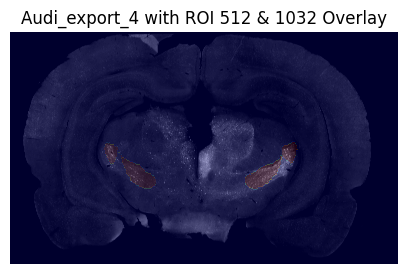

In [ ]:
ROI_idx = np.array([164,200,204,235,238,257,284,287])
ROI_idx_new = 512

curSubject = "Audi"
print(f"Processing subject: {curSubject}")
# Define the path to the JSON file
json_path = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/downsampled_CellPose/MyResults.json"

# Load the JSON data from the file
with open(json_path, 'r') as file:
    data = json.load(file)

    # Access the "slices" feature
    slices = data.get("slices", [])
    
# Define directories
image_dir_downsampled = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/"

# Create a folder for figures
folderName = f"{ROI_idx}_histology_overlay/"
if not os.path.exists(image_dir_downsampled + folderName):
    os.makedirs(image_dir_downsampled + folderName)
    


curSlice = slices[2]

fileName = curSlice['filename']
print(fileName)

Oxyz = curSlice['anchoring'][:3]
Uxyz = curSlice['anchoring'][3:6]
Vxyz = curSlice['anchoring'][6:]

# Load the histology image
image_path = os.path.join(image_dir_downsampled, fileName)
image = io.imread(image_path, as_gray=True)
width, height = image.shape[1], image.shape[0]
print(f"Image shape: {image.shape}, Width: {width}, Height: {height}")

# Extract and upsample the atlas slice
atlas_slice = extract_section(atlas_data, Oxyz, Uxyz, Vxyz, output_size=None)
ROI_indices = np.unique(atlas_slice)
atlas_slice_upsampled = upsample_and_pad_atlas_slice(atlas_slice, (height, width))

cropped_image, crop_bbox, cropped_mask = crop_roi_for_cellpose(image, ROI_mask)

# Plot the hist image overlap with the atlas slice
# plt.figure(figsize=(5, 5))
# plt.imshow(image, cmap='gray')
# plt.imshow(atlas_slice_upsampled, cmap='jet', alpha=0.5)
# plt.axis('off')
# plt.title('Histology Image with Atlas Slice Overlay')

# Plot ROI mask

ROI_mask = np.isin(atlas_slice_upsampled, ROI_idx).astype(np.uint8)
ROI_mask2 = np.isin(atlas_slice_upsampled, ROI_idx + 520).astype(np.uint8)
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.imshow(ROI_mask, cmap='jet', alpha=0.2)
plt.imshow(ROI_mask2, cmap='jet', alpha=0.2)  # Overlay the right side mask for comparison
plt.axis('off')
figName = fileName.split('.')[0]  # Remove file extension for a cleaner title
plt.title(f'{figName} with ROI {ROI_idx_new} & {ROI_idx_new+520} Overlay')
plt.savefig(os.path.join(image_dir_downsampled, folderName, f"{figName}_ROI_{ROI_idx_new}_overlay.png"), bbox_inches='tight', pad_inches=0.1)


In [ ]:
image = io.imread(image_path, as_gray=True)

## Feed all the images into CellPose and do cell counting

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import cellpose
from cellpose import models, io
from cellpose.io import imread

subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
for curSubject in subject_Names: 
   print(f"Processing subject: {curSubject}")

   # Define directories
   ROI_dir = f"../data/ROI/{curSubject}/"
   image_dir = os.path.abspath(os.path.join(ROI_dir, os.pardir))

   # Find all cropped images and feed them into CellPose
   cropped_image_paths = [os.path.join(ROI_dir, f) for f in os.listdir(ROI_dir) if f.endswith('_cropped.png')]
   # cropped_image_paths = [ROI_dir + "Audi_export_3_ROI_513_cropped.png",
   #                        ROI_dir + "Audi_export_6_ROI_508_cropped.png",
   #                           ROI_dir + "Audi_export_9_ROI_508_cropped.png",
   #                        ]
   print(f"Found {len(cropped_image_paths)} cropped images for CellPose processing.")

   # Extract fileNmaes and ROI indices from the filenames
   file_names = [f.split('_ROI_')[0] for f in cropped_image_paths]
   ROI_indices = [int(f.split('_ROI_')[1].split('_')[0]) for f in cropped_image_paths]
   
   # # Optional: we just want [511, 1031] for the current subject
   # file_names = [file_name for file_name, roi in zip(file_names, ROI_indices) if roi in [511, 1031]]
   # cropped_image_paths = [path for path, roi in zip(cropped_image_paths, ROI_indices) if roi in [511, 1031]]
   # ROI_indices = [ROI for ROI in ROI_indices if ROI in [511, 1031]]


   # Let the CellPose model run
   modelPath = "C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/CellPose_Finetuning/models/PoM_062025"
   io.logger_setup()
   model = models.CellposeModel(gpu=True, pretrained_model=modelPath)
   imgs = [imread(f) for f in cropped_image_paths]
   nimg = len(cropped_image_paths)
   masks, flows, styles = model.eval(imgs)
   Cell_counts = [len(np.unique(mask)) - 1 for mask in masks]  # Subtract 1 for background

   # Compute the mean intensity and median intensity of each image
   # We should exclude 0 values, because we padded the images with zeros
   # This is to avoid division by zero in mean calculation
   mean_intensities = [np.sum(img) / np.count_nonzero(img) if np.count_nonzero(img) > 0 else 0 for img in imgs]
   median_intensities = [np.median(img[img > 0]) if np.count_nonzero(img) > 0 else 0 for img in imgs]

   # Write three measurements into Audi_ROI_hist_results.csv
   # Read the existing CSV file in the parent directory
   parent_dir = f"../data/HighPass_GPU/{curSubject}/"
   csv_path = os.path.join(parent_dir, f"{curSubject}_ROI_hist_results.csv")
   df = pd.read_csv(csv_path)

   # For each processed cropped image, update the corresponding row in the DataFrame
   for i, (roi_idx, cell_count, mean_int, median_int) in enumerate(zip(ROI_indices, Cell_counts, mean_intensities, median_intensities)):
      # Find the row matching both filename and ROI_index
      # Extract the original filename from the cropped image path
      cropped_img_name = os.path.basename(cropped_image_paths[i])
      # Try to extract the original filename (before "_ROI_")
      orig_filename = cropped_img_name.split('_ROI_')[0] + '.png'
      mask = (df['filename'] == orig_filename) & (df['ROI_index'] == roi_idx)
      df.loc[mask, 'Cell_count'] = cell_count
      df.loc[mask, 'Mean_intensity'] = mean_int
      df.loc[mask, 'Median_intensity'] = median_int

   # Save the updated DataFrame back to CSV
   df.to_csv(csv_path, index=False)

   # For each image, save the mask and flow
   cellpose.io.save_masks(imgs, masks, flows,file_names=cropped_image_paths, png=True)
   
   # Clear the memory
   del model, imgs, masks, flows, styles



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.12.1 
torch version:  	2.7.1+cu118! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [41]:
cropped_image_paths

['C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1028_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1029_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1030_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1031_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1033_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_ROI_1034_cropped.png',
 'C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/Raw_PNG/ROI/Experiment-7982-Shading Correction-32_R

## Add new ROIs, run the whole pipeline and add to the result

In [ ]:
# Add new ROIs, run the segmentation, run through CellPose 
# and save the intensity values and cell counts
import os
import json
import numpy as np
import pandas as pd
from skimage import io
from matplotlib import pyplot as plt
import glob
from PIL import Image
import nibabel as nib

ROI_to_add_L = [417, 422]
ROI_to_add_R = [ROI + 520 for ROI in ROI_to_add_L]
print(f"Adding new ROIs: {ROI_to_add_L} and {ROI_to_add_R}")
ROI_toadd_all = ROI_to_add_L + ROI_to_add_R
ROI_toadd_info = region_index(ROI_to_add_L, regions)
ROI_toadd_names = [ROI['name'].replace('"', '') for ROI in ROI_toadd_info] * 2

subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]

atlas_path = "D:/Histology_analysis/WHS_SD_rat_atlas_v4_pack/WHS_SD_rat_atlas_v4_asymmetric.nii"
atlas_data = nib.load(atlas_path).get_fdata()
print(atlas_data.shape)

Image.MAX_IMAGE_PIXELS = 400000000  # or None to disable the check entirely

for curSubject in subject_Names:
    print(f"Processing subject: {curSubject}")
    # Define the path to the JSON file
    json_path = f"../data/Downsampled/{curSubject}/MyResults.json"

    # Load the JSON data from the file
    with open(json_path, 'r') as file:
        data = json.load(file)

    # Access the "slices" feature
    slices = data.get("slices", [])
    
    # Define directories
    image_png_dir = f"../data/HighPass_GPU/{curSubject}/"
    imagePaths = glob.glob(os.path.join(image_png_dir, "*.tif")) + glob.glob(os.path.join(image_png_dir, "*.png"))
    # with the ROI mask and computing the mean intensity in the masked region

    if len(slices) != len(imagePaths):
        ValueError(f"Number of slices in JSON ({len(slices)}) does not match number of images ({len(imagePaths)}) for subject {curSubject}.")
    # Create a folder for figures
    fig_savepath = f"../data/ROI/{curSubject}/"
    os.makedirs(fig_savepath, exist_ok=True)
    
    hist_results = []
    # Loop through each slice and process the corresponding image
    for i, curSlice in enumerate(slices):
        fileName = curSlice['filename']
        # width, height = curSlice['width'], curSlice['height']
        Oxyz = curSlice['anchoring'][:3]
        Uxyz = curSlice['anchoring'][3:6]
        Vxyz = curSlice['anchoring'][6:]

        # Load the histology image
        # Change the suffix '.png' to '_highpass.png' for fileName
        
        image_fileName = fileName[:-4] + '_highpass.png'
        
        image_path = os.path.join(image_png_dir, image_fileName)
        if not os.path.exists(image_path):
            print(f"Image file {image_path} does not exist. Skipping this slice.")
            continue
        image_raw = io.imread(image_path)
        width, height = image_raw.shape[1], image_raw.shape[0]
        image = image_raw[:, :, 0]  # Assuming the first channel:red

        # Extract and upsample the atlas slice
        atlas_slice = extract_section(atlas_data, Oxyz, Uxyz, Vxyz, output_size=None)
        curSlice_ROIs = np.unique(atlas_slice).astype(np.int32)
        atlas_slice_upsampled = upsample_and_pad_atlas_slice(atlas_slice, (height, width))
        for i, ROI_index in enumerate(ROI_toadd_all):  # Skip background (index 0)
            # ROI name
            # ROI_name = region_index(ROI_index, regions)['name']
            # Generate a mask for the current ROI
            ROI_index_new = ROI_toadd_all[i]
            
            # For all ROIs, combine them and give them the new index from ROI_num2
            if np.any(np.isin(ROI_index, curSlice_ROIs)):
                # Create a mask for all ROI_index values in the upsampled atlas slice
                ROI_mask = np.isin(atlas_slice_upsampled, ROI_index).astype(np.uint8)
                
                # Calculate the hist pixel number and atlas voxel number
                hist_pixel_num = np.sum(ROI_mask > 0)
                atlas_voxel_num = np.sum(np.isin(atlas_slice, ROI_index))
                
                # Segment out ROIs
                cropped_image, crop_bbox, cropped_mask = crop_roi_for_cellpose(image, ROI_mask)

                if cropped_image is not None and len(cropped_image) > 100:
                    # Store the results in a dictionary
                    result = {
                            'filename': fileName,
                            'ROI_index': ROI_index_new,
                            'ROI_name': ROI_toadd_names[i],
                            'hist_pixel_num': hist_pixel_num,
                            'atlas_voxel_num': atlas_voxel_num
                              }
                    hist_results.append(result)
                    
                    # Save the cropped image
                    cropped_image_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{ROI_index_new}_cropped.png")
                    # Ensure cropped_image is uint8 for PNG
                    if cropped_image.dtype != np.uint8:
                        cropped_image_to_save = np.clip(cropped_image, 0, 255).astype(np.uint8)
                    else:
                        cropped_image_to_save = cropped_image
                    io.imsave(cropped_image_path, cropped_image_to_save)
                    
                    # # Save the cropped mask (convert to uint8 for PNG)
                    # cropped_mask_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{ROI_index_new}_mask.png")
                    # cropped_mask_to_save = (cropped_mask > 0).astype(np.uint8) * 255
                    # io.imsave(cropped_mask_path, cropped_mask_to_save)
                    del cropped_image_to_save, cropped_image
    
    # Create a DataFrame from the results
    df_toadd = pd.DataFrame(hist_results)
    # Save the DataFrame to a CSV file
    toadd_csv_path = os.path.join(image_png_dir, f"{curSubject}_ROI_hist_results.csv")
    if os.path.exists(toadd_csv_path):
        df_existing = pd.read_csv(toadd_csv_path)
        df = pd.concat([df_existing, df_toadd], ignore_index=True)
    df.to_csv(toadd_csv_path, index=False)
    print(f"Saved results for {curSubject} to {toadd_csv_path}")
        
                
print('DONE! All images processed and saved.')
del atlas_slice, atlas_slice_upsampled, crop_bbox, cropped_mask

import cellpose
from cellpose import models, io
from cellpose.io import imread

for curSubject in subject_Names: 
   print(f"Processing subject: {curSubject}")

   # Define directories
   ROI_dir = f"../data/ROI/{curSubject}/"
   image_dir = os.path.abspath(os.path.join(ROI_dir, os.pardir))

   # Find all cropped images and feed them into CellPose
   cropped_image_paths = [os.path.join(ROI_dir, f) for f in os.listdir(ROI_dir) if f.endswith('_cropped.png')]
   print(f"Found {len(cropped_image_paths)} cropped images for CellPose processing.")

   # Extract fileNmaes and ROI indices from the filenames
   file_names = [f.split('_ROI_')[0] for f in cropped_image_paths]
   ROI_indices = [int(f.split('_ROI_')[1].split('_')[0]) for f in cropped_image_paths]
   
   # Optional: we just want [511, 1031] for the current subject
   file_names_toadd = [file_name for file_name, roi in zip(file_names, ROI_indices) if roi in ROI_toadd_all]
   cropped_image_paths_toadd = [path for path, roi in zip(cropped_image_paths, ROI_indices) if roi in ROI_toadd_all]
   ROI_indices_toadd = [ROI for ROI in ROI_indices if ROI in ROI_toadd_all]


   # Let the CellPose model run
   modelPath = "C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/CellPose_Finetuning/models/PoM_062025"
   io.logger_setup()
   model = models.CellposeModel(gpu=True, pretrained_model=modelPath)
   imgs = [imread(f) for f in cropped_image_paths_toadd]
   nimg = len(cropped_image_paths_toadd)
   masks, flows, styles = model.eval(imgs)
   Cell_counts = [len(np.unique(mask)) - 1 for mask in masks]  # Subtract 1 for background

   # Compute the mean intensity and median intensity of each image
   # We should exclude 0 values, because we padded the images with zeros
   # This is to avoid division by zero in mean calculation
   mean_intensities = [np.sum(img) / np.count_nonzero(img) if np.count_nonzero(img) > 0 else 0 for img in imgs]
   median_intensities = [np.median(img[img > 0]) if np.count_nonzero(img) > 0 else 0 for img in imgs]

   # Write three measurements into Audi_ROI_hist_results.csv
   # Read the existing CSV file in the parent directory
   parent_dir = f"../data/HighPass_GPU/{curSubject}/"
   csv_path = os.path.join(parent_dir, f"{curSubject}_ROI_hist_results.csv")
   df = pd.read_csv(csv_path)

   # For each processed cropped image, update the corresponding row in the DataFrame
   for i, (roi_idx, cell_count, mean_int, median_int) in enumerate(zip(ROI_indices, Cell_counts, mean_intensities, median_intensities)):
      # Find the row matching both filename and ROI_index
      # Extract the original filename from the cropped image path
      cropped_img_name = os.path.basename(cropped_image_paths_toadd[i])
      # Try to extract the original filename (before "_ROI_")
      orig_filename = cropped_img_name.split('_ROI_')[0] + '.png'
      mask = (df['filename'] == orig_filename) & (df['ROI_index'] == roi_idx)
      df.loc[mask, 'Cell_count'] = cell_count
      df.loc[mask, 'Mean_intensity'] = mean_int
      df.loc[mask, 'Median_intensity'] = median_int

   # Save the updated DataFrame back to CSV
   df.to_csv(csv_path, index=False)

   # For each image, save the mask and flow
   cellpose.io.save_masks(imgs, masks, flows,file_names=cropped_image_paths_toadd, png=True)
   
   # Clear the memory
   del model, imgs, masks, flows, styles

In [7]:
import cellpose
from cellpose import models, io
from cellpose.io import imread
subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]

for curSubject in subject_Names: 
   print(f"Processing subject: {curSubject}")

   # Define directories
   ROI_dir = f"../data/ROI/{curSubject}/"
   image_dir = os.path.abspath(os.path.join(ROI_dir, os.pardir))

   # Find all cropped images and feed them into CellPose
   cropped_image_paths = [os.path.join(ROI_dir, f) for f in os.listdir(ROI_dir) if f.endswith('_cropped.png')]
   print(f"Found {len(cropped_image_paths)} cropped images for CellPose processing.")

   # Extract fileNmaes and ROI indices from the filenames
   file_names = [f.split('_ROI_')[0] for f in cropped_image_paths]
   ROI_indices = [int(f.split('_ROI_')[1].split('_')[0]) for f in cropped_image_paths]
   
   # Optional: we just want [511, 1031] for the current subject
   file_names_toadd = [file_name for file_name, roi in zip(file_names, ROI_indices) if roi in ROI_toadd_all]
   cropped_image_paths_toadd = [path for path, roi in zip(cropped_image_paths, ROI_indices) if roi in ROI_toadd_all]
   ROI_indices_toadd = [ROI for ROI in ROI_indices if ROI in ROI_toadd_all]


   # Let the CellPose model run
   modelPath = "C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/CellPose_Finetuning/models/PoM_062025"
   io.logger_setup()
   model = models.CellposeModel(gpu=True, pretrained_model=modelPath)
   imgs = [imread(f) for f in cropped_image_paths_toadd]
   nimg = len(cropped_image_paths_toadd)
   masks, flows, styles = model.eval(imgs)
   Cell_counts = [len(np.unique(mask)) - 1 for mask in masks]  # Subtract 1 for background

   # Compute the mean intensity and median intensity of each image
   # We should exclude 0 values, because we padded the images with zeros
   # This is to avoid division by zero in mean calculation
   mean_intensities = [np.sum(img) / np.count_nonzero(img) if np.count_nonzero(img) > 0 else 0 for img in imgs]
   median_intensities = [np.median(img[img > 0]) if np.count_nonzero(img) > 0 else 0 for img in imgs]

   # Write three measurements into Audi_ROI_hist_results.csv
   # Read the existing CSV file in the parent directory
   parent_dir = f"../data/HighPass_GPU/{curSubject}/"
   csv_path = os.path.join(parent_dir, f"{curSubject}_ROI_hist_results.csv")
   df = pd.read_csv(csv_path)

   # For each processed cropped image, update the corresponding row in the DataFrame
   for i, (roi_idx, cell_count, mean_int, median_int) in enumerate(zip(ROI_indices, Cell_counts, mean_intensities, median_intensities)):
      # Find the row matching both filename and ROI_index
      # Extract the original filename from the cropped image path
      cropped_img_name = os.path.basename(cropped_image_paths_toadd[i])
      # Try to extract the original filename (before "_ROI_")
      orig_filename = cropped_img_name.split('_ROI_')[0] + '.png'
      mask = (df['filename'] == orig_filename) & (df['ROI_index'] == roi_idx)
      df.loc[mask, 'Cell_count'] = cell_count
      df.loc[mask, 'Mean_intensity'] = mean_int
      df.loc[mask, 'Median_intensity'] = median_int

   # Save the updated DataFrame back to CSV
   df.to_csv(csv_path, index=False)

   # For each image, save the mask and flow
   cellpose.io.save_masks(imgs, masks, flows,file_names=cropped_image_paths_toadd, png=True)
   
   # Clear the memory
   del model, imgs, masks, flows, styles

Processing subject: Audi
Found 100 cropped images for CellPose processing.
2025-07-15 19:18:15,971 [INFO] WRITING LOG OUTPUT TO C:\Users\Wenji\.cellpose\run.log
2025-07-15 19:18:15,973 [INFO] 
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.12.1 
torch version:  	2.7.1+cu118
2025-07-15 19:18:16,211 [INFO] ** TORCH CUDA version installed and working. **
2025-07-15 19:18:16,211 [INFO] >>>> using GPU (CUDA)
2025-07-15 19:18:18,601 [INFO] >>>> loading model C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/CellPose_Finetuning/models/PoM_062025
2025-07-15 19:23:30,196 [INFO] 100%|##########| 24/24 [05:09<00:00, 12.89s/it]
2025-07-15 19:23:32,294 [WARNING] no masks found, will not save PNG or outlines
2025-07-15 19:23:32,745 [WARNING] no masks found, will not save PNG or outlines
Processing subject: Honda
Found 116 cropped images for CellPose processing.
creating new log file
2025-07-15 19:23:33,152 [INFO] WRITING LOG OUTPUT TO C:\Users\Wenji\.cellpose\run.

## Combine the measurements of same ROIs across slices

In [8]:
# Define the voxel size of the atlas (each version and each animal may be different)
voxel_size = (39, 39, 39) # Example voxel size in micrometers (x, y, z)

In [10]:
df

,filename,ROI_index,ROI_name,hist_pixel_num,atlas_voxel_num,Cell_count,Mean_intensity,Median_intensity
0,Audi_export_1.png,508,SC_L,4695382,4546,29.0,11.992639,7.0
1,Audi_export_1.png,1028,SC_R,4228618,4095,233.0,21.290774,11.0
2,Audi_export_1.png,509,AS_L,148609,144,0.0,6.418639,5.0
3,Audi_export_1.png,1029,AS_R,159810,155,1.0,8.622348,5.0
4,Audi_export_1.png,511,PRT_L,433832,420,0.0,8.933485,7.0
...,...,...,...,...,...,...,...,...
131,Audi_export_13.png,942,Secondary somatosensory area,2155822,1854,4.0,8.530693,6.0
132,Audi_export_16.png,417,"Primary somatosensory area, forelimb represent...",2695123,2038,NaN,NaN,NaN
133,Audi_export_16.png,937,"Primary somatosensory area, forelimb represent...",2908410,2199,0.0,7.943278,6.0
134,Audi_export_11.png,417,"Primary somatosensory area, forelimb represent...",2466505,1972,NaN,NaN,NaN


In [15]:
for curSubject in subject_Names:
    print(f"Combining results for subject: {curSubject}")
    # Define directories

    image_dir = f"../data/HighPass_GPU/{curSubject}/"
    input_csv_path = os.path.join(image_dir, f"{curSubject}_ROI_hist_results.csv")
    output_csv_path = os.path.join(image_dir, f"{curSubject}_ROI_hist_results_combined.csv")
    # Read the input CSV file
    df = pd.read_csv(input_csv_path)

    df_combined = pd.DataFrame(columns=['filename', 'ROI_index', 'ROI_name', 'hist_pixel_num', 'atlas_voxel_num', 'Cell_count', 'Mean_intensity', 'Median_intensity'])

    # Combine the results for each ROI index
    # Calculate the weighted sum of mean intensities, median intensities, and cell counts
    unique_roi_indices = df['ROI_index'].unique()
    for roi_index in unique_roi_indices:
        # Filter rows for the current ROI index
        roi_rows = df[df['ROI_index'] == roi_index]
        
        if not roi_rows.empty:
            # Calculate the weighted mean intensity, median intensity, and cell count
            total_hist_pixel_num = roi_rows['hist_pixel_num'].sum()
            total_atlas_voxel_num = roi_rows['atlas_voxel_num'].sum()
            
            weighted_mean_intensity = np.sum(roi_rows['Mean_intensity'] * roi_rows['atlas_voxel_num']) / total_atlas_voxel_num
            weighted_median_intensity = np.sum(roi_rows['Median_intensity'] * roi_rows['atlas_voxel_num']) / total_atlas_voxel_num
            total_cell_count = roi_rows['Cell_count'].sum()
            observed_region_size = total_atlas_voxel_num * np.prod(voxel_size) / 1e9  # in cubic mm^2
            cell_density = total_cell_count / observed_region_size # units: cells/mm^3  
            
            # Effect score = cell density * CBF
            curcfb = cbf_values.get(roi_index, 0.85)  # Default CBF value to be the same as thalamus if not found
            effect_score = cell_density * curcfb
            
            # Store the combined results in a new DataFrame
            combined_results = {
                # Use the first filename as representative
                'ROI_index': roi_index,
                'ROI_name': roi_rows['ROI_name'].iloc[0],  # Use the first ROI name as representative
                'hist_pixel_num': total_hist_pixel_num,
                'atlas_voxel_num': total_atlas_voxel_num,
                'Cell_count': total_cell_count,
                'Mean_intensity': weighted_mean_intensity,
                'Median_intensity': weighted_median_intensity,
                'Observed_region_size_mm3': observed_region_size,
                'Cell_density_cells_per_mm3': cell_density,
                'CBF (ml/gram/min)': curcfb, # Cerebral blood flow value for the ROI
                'Effect_score': effect_score # Effect score
            }
            
            # Append the combined results to the new DataFrame
            df_combined = df_combined.append(combined_results, ignore_index=True)
            
    # Save the combined results to a new CSV file
    df_combined.to_csv(output_csv_path, index=False)
    print(f"Combined results saved to {output_csv_path}")

Combining results for subject: Audi
Combined results saved to ../data/HighPass_GPU/Audi/Audi_ROI_hist_results_combined.csv
Combining results for subject: Honda
Combined results saved to ../data/HighPass_GPU/Honda/Honda_ROI_hist_results_combined.csv
Combining results for subject: Kappa
Combined results saved to ../data/HighPass_GPU/Kappa/Kappa_ROI_hist_results_combined.csv
Combining results for subject: Kia
Combined results saved to ../data/HighPass_GPU/Kia/Kia_ROI_hist_results_combined.csv
Combining results for subject: Liam
Combined results saved to ../data/HighPass_GPU/Liam/Liam_ROI_hist_results_combined.csv
Combining results for subject: Pat
Combined results saved to ../data/HighPass_GPU/Pat/Pat_ROI_hist_results_combined.csv
Combining results for subject: toyota
Combined results saved to ../data/HighPass_GPU/toyota/toyota_ROI_hist_results_combined.csv


# Change the csv file

In [34]:
import os
import numpy as np
import pandas as pd

subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
for curSubject in subject_Names:
    print (f"Processing subject: {curSubject}")
    # Define directories
    image_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/"
    input_csv_path = os.path.join(image_dir, f"{curSubject}_ROI_hist_results_combined.csv")
    data = pd.read_csv(input_csv_path)
    # Delete the following rows with specific ROI indices
    rows_to_delete = [507, 1027, 508, 1028, 509, 1029, 510, 1030, 511, 1031, 
                    230, 267, 408, 420, 422, 425, 750, 787, 928, 940, 942, 945]
    data = data[~data['ROI_index'].isin(rows_to_delete)]

    # Delete the 'filename' column
    if 'filename' in data.columns:
        print("Dropping 'filename' column from the DataFrame.")
        data = data.drop(columns=['filename'])
        
    # Rename the ROI_index with new index
    old_indices = [512, 1032, 513, 1033, 514, 1034, 515, 1035]
    new_indices = [507, 1027, 508, 1028, 509, 1029, 510, 1030]
    data['ROI_index'] = data['ROI_index'].replace(dict(zip(old_indices, new_indices)))

    # Save the modified DataFrame back to a new CSV file
    output_csv_path = os.path.join(image_dir, f"{curSubject}_ROI_hist_results_combined_modified.csv")
    data.to_csv(output_csv_path, index=False)   

Processing subject: Audi
Dropping 'filename' column from the DataFrame.
Processing subject: Honda
Dropping 'filename' column from the DataFrame.
Processing subject: Kappa
Dropping 'filename' column from the DataFrame.
Processing subject: Kia
Dropping 'filename' column from the DataFrame.
Processing subject: Liam
Dropping 'filename' column from the DataFrame.
Processing subject: Pat
Dropping 'filename' column from the DataFrame.
Processing subject: toyota
Dropping 'filename' column from the DataFrame.


In [11]:
data

,ROI_index,ROI_name,hist_pixel_num,atlas_voxel_num,Cell_count,Mean_intensity,Median_intensity,CBF (ml/gram/min),Cell_density_cells_per_mm3,Effect_score,Observed_region_size_mm3
0,505,Sen_L,5309321,5264,0.0,72.150421,71.342895,0.85,0.000000,0.000000,0.312255
1,1025,Sen_R,5886715,5827,0.0,74.978455,73.953321,0.85,0.000000,0.000000,0.345652
2,506,Mo_L,2926486,2948,10.0,57.956826,55.633989,0.85,57.184549,48.606867,0.174872
3,1026,Mo_R,2729710,2751,22.0,65.090852,62.773900,0.85,134.815017,114.592764,0.163187
14,507,ZI_L,5373810,5219,111.0,59.980554,57.302357,0.76,358.543506,272.493065,0.309586
15,1027,ZI_R,5205095,5055,284.0,84.724310,77.035015,0.76,947.116405,719.808468,0.299858
16,508,SC_L,12863473,13097,261.0,65.012863,65.753379,0.92,335.950165,309.074152,0.776901
17,1028,SC_R,11595957,11819,783.0,81.646357,79.611642,0.92,1116.830352,1027.483924,0.701091
18,509,AS_L,7600321,7524,4.0,61.522742,60.625731,0.85,8.962257,7.617918,0.446316
19,1029,AS_R,7222639,7163,14.0,62.840426,62.204523,0.85,32.948774,28.006458,0.424902


In [95]:
# Save the updated DataFrame back to CSV
df.to_csv(csv_path, index=False)

In [81]:
median_intensities = [np.median(img[img > 0]) if np.count_nonzero(img) > 0 else 0 for img in imgs]
median_intensities

[46.0, 44.0, 93.0]

In [80]:

mean_intensities = [np.sum(img) / np.count_nonzero(img) if np.count_nonzero(img) > 0 else 0 for img in imgs]
mean_intensities

[44.08603528314375, 43.384475484699564, 96.90002332116083]

In [64]:
cellpose.io.save_masks(imgs, masks, flows,file_names=cropped_image_paths, png=True)

2025-06-17 23:38:56,770 [WARNING] no masks found, will not save PNG or outlines
2025-06-17 23:38:56,771 [WARNING] no masks found, will not save PNG or outlines


In [75]:
np.sum(imgs[2]>0)

703224

In [78]:
np.count_nonzero(imgs[2])

703224

In [76]:
703224/(920*983)

0.7775929939404662

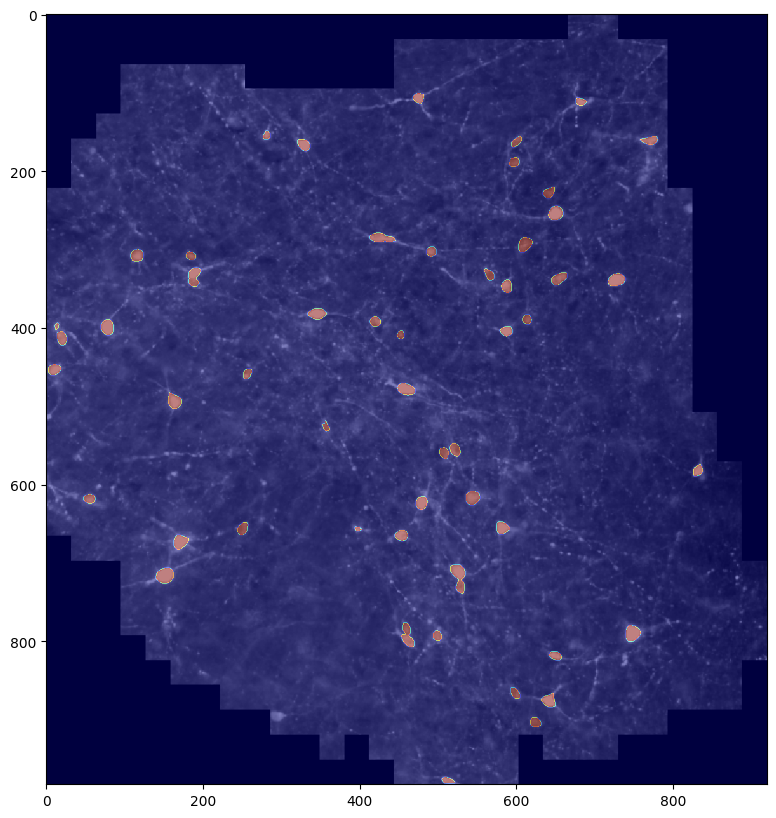

In [68]:
plt.figure(figsize=(10, 10))
plt.imshow(imgs[2], cmap='gray')
plt.imshow(masks[2]> 0, cmap='jet', alpha=0.5)

## See the cell segmentation results of ROIs

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subject_Names = ["Audi", "Honda", "Kappa", "Kia", "Liam", "Pat", "toyota"]
target_ROIs = [507, 508, 1027, 1028]  # Example ROI indices to keep
output_dir = f"D:/Histology_analysis/Results/YK_ROIs/{target_ROIs[0]}_{target_ROIs[1]}/"
os.makedirs(output_dir, exist_ok=True)
for curSubject in subject_Names:
    roi_dir = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/Raw_PNG/ROI/"
    
    # Search for all cropped images and masks and plot overlay
    cropped_image_paths = [os.path.join(roi_dir, f) for f in os.listdir(roi_dir) if f.endswith('_cropped.png')]
    for roi_idx in target_ROIs:
        # Find cropped image and corresponding mask for this ROI
        cropped_img = [p for p in cropped_image_paths if f"_ROI_{roi_idx}_" in p]
        mask_path = [p.replace('_cropped.png', '_cropped_cp_masks.png') for p in cropped_img]
        for img_path, msk_path in zip(cropped_img, mask_path):
            if os.path.exists(img_path) and os.path.exists(msk_path):
                img = plt.imread(img_path)
                mask = plt.imread(msk_path)
                plt.figure(figsize=(6, 6))
                plt.imshow(img, cmap='gray')
                plt.imshow(mask>0, cmap='jet', alpha=0.4)
                plt.axis('off')
                plt.title(f"{curSubject} ROI {roi_idx}")
                save_name = os.path.basename(img_path).replace('_cropped.png', f'_overlay.png')
                # Save the figure as an image with original resolution, no compression
                plt.savefig(
                    os.path.join(output_dir, f"{curSubject}_{save_name}"),
                    bbox_inches='tight',
                    pad_inches=0.1,
                    dpi=img.shape[1] / plt.gcf().get_size_inches()[0],  # set dpi to match original width
                    format='png'
                )
                plt.close()
    

In [57]:
Cell_counts

[0, 0, 56]

In [44]:
if np.any(np.isin(ROI_index, curSlice_ROIs)):
    print("At least one element in ROI_index is present in curSlice_ROIs.")
else:
    print("No elements in ROI_index are present in curSlice_ROIs.")

At least one element in ROI_index is present in curSlice_ROIs.


In [ ]:
# import os
# import json
# import numpy as np
# import pandas as pd
# from skimage import io
# from matplotlib import pyplot as plt

# # Define directories
# # image_dir_normalized = "/mnt/c/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/normalized/"
# # image_dir_clean = "/mnt/c/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/toyota/clean/"
# image_dir_downsampled = f"C:/Users/Wenji/OneDrive/Desktop/Jasanoff Lab/Histology analysis/{curSubject}/downsampled_CellPose/"
# # For each slice, calculate the average intensity of each ROI by masking out the histology image
# # with the ROI mask and computing the mean intensity in the masked region

# # Create a folder for figures
# fig_savepath = os.path.join(image_dir_downsampled, "ROI/")
# os.makedirs(fig_savepath, exist_ok=True)


# hist_intensities = []
# for curSlice in slices:
#     fileName = curSlice['filename']
#     width, height = curSlice['width'], curSlice['height']
#     Oxyz = curSlice['anchoring'][:3]
#     Uxyz = curSlice['anchoring'][3:6]
#     Vxyz = curSlice['anchoring'][6:]

#     # Load the histology image
#     image_path = os.path.join(image_dir_downsampled, fileName)
#     image_raw = io.imread(image_path)
#     image = image_raw[:, :, 0]  # Assuming the first channel:red

#     # Extract and upsample the atlas slice
#     atlas_slice = extract_section(atlas_data, Oxyz, Uxyz, Vxyz, output_size=None)
#     curROI_indices = np.unique(atlas_slice)
#     atlas_slice_upsampled = upsample_and_pad_atlas_slice(atlas_slice, (height, width))
    

#     for i, ROI_index in enumerate(ROI_list2):  # Skip background (index 0)
#         # ROI name
#         # ROI_name = region_index(ROI_index, regions)['name']
#         # Generate a mask for the current ROI
#         ROI_index_new = ROI_num2[i]
        
#         # Now ROI_index is a list of indices, so we need to loop through them
#         for index in ROI_index:
#             if index in curROI_indices:
#                 ROI_mask = np.zeros(atlas_slice_upsampled.shape)
#                 ROI_mask[atlas_slice_upsampled == index] = 1
                
#                 # Calculate the hist pixel number and atlas voxel number
#                 hist_pixel_num = np.sum(ROI_mask)
#                 atlas_voxel_num = np.sum(atlas_slice == index)
                
#                 # Get the indices of the ROI region
#                 roi_indices = np.where(ROI_mask > 0)
                
#                 # Segment out ROIs
#                 cropped_image, crop_bbox, cropped_mask = crop_roi_for_cellpose(image, ROI_mask)
#                 # Save the cropped image and mask
#                 if cropped_image is not None:
#                     # Save the cropped image
#                     cropped_image_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{index}_cropped.png")
#                     # Ensure cropped_image is uint8 for PNG
#                     if cropped_image.dtype != np.uint8:
#                         cropped_image_to_save = np.clip(cropped_image, 0, 255).astype(np.uint8)
#                     else:
#                         cropped_image_to_save = cropped_image
#                     io.imsave(cropped_image_path, cropped_image_to_save)
                    
#                     # Save the cropped mask (convert to uint8 for PNG)
#                     cropped_mask_path = os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{index}_mask.png")
#                     cropped_mask_to_save = (cropped_mask > 0).astype(np.uint8) * 255
#                     io.imsave(cropped_mask_path, cropped_mask_to_save)
                    
#                     # Plot the cropped image with the mask overlay
#                     plt.figure(figsize=(5, 5))
#                     plt.imshow(cropped_image_to_save, cmap='gray')
#                     plt.imshow(cropped_mask_to_save, cmap='jet', alpha=0.5)
#                     plt.axis('off')
#                     plt.title(f'{fileName.split(".")[0]} ROI {index} Overlay')
#                     plt.savefig(os.path.join(fig_savepath, f"{fileName.split('.')[0]}_ROI_{index}_overlay.png"), bbox_inches='tight', pad_inches=0.1)
#                     plt.close()  # Close the figure to free memory
#                     # Optionally, delete large arrays if not needed anymore
#                     del cropped_image, cropped_image_to_save, cropped_mask, cropped_mask_to_save

# print(f"Processed {len(slices)} slices and saved cropped images and masks to {fig_savepath}")

NameError: name 'curSubject' is not defined